# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sdf
import re
import glob
from tqdm import tqdm
import sys
from style import *
from tabulate import tabulate

plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = (10, 8)

In [2]:
c = 299792458
PI = np.pi
pi = PI

# Individual Functions

In [40]:
DATA_DIR = "run_1"
ALL_FILES = glob.glob(f"{DATA_DIR}/*sdf")
ALL_FILES.sort()
POINTS = len(ALL_FILES)

In [41]:
c = 299792458
PI = np.pi
# epsilon = 8.85e-12

with open(os.path.join(DATA_DIR, "input.deck"), "r") as myfile:
    data = myfile.read()

def find_value(info):
    regex = re.compile(rf"\s{info}\s*=\s*-?(\d+\.?\d*)")
    regex2 = re.compile(rf"\s*{info}\s*=\s*(.*)\n")
    match = regex.search(data)
    match2 = regex2.search(data)

    if match:
        return float(match.group(1))
    
    if match2:
        return float(eval(match2.group(1)))
    else:
        return None

LAMBD = find_value("lambda0") * 1e-6
LAS_TIME = int(find_value("las_time"))
T_MAX = int(find_value("t_end"))
DT = find_value("dt_snapshot") * 1e-15
A0 = find_value("a0")
FACTOR = int(find_value("factor"))
NX = int(find_value("nx"))
X_MIN = -int(find_value("x_min"))
ANGLE = find_value("alpha")
pol = find_value("polarisation")

if pol is None:
    POL_TYPE = "p"
    POL_ANGLE = 0
else:
    if float(pol) == 90.0:
        POL_ANGLE = 90
        POL_TYPE = "s"
    else:
        POL_ANGLE = float(pol)
        POL_TYPE = "p" 


beta = np.cos((ANGLE))
tan_factor = np.tan((ANGLE))

lambda_0 = LAMBD
omega_0 = 2 * PI * c / lambda_0
tau_0 = 2 * PI / omega_0

lambda_m = LAMBD / beta
omega_m = 2 * PI * c / lambda_m
tau_m = 2 * PI / omega_m
dt_m = DT
dt_l = DT

lambda_l = lambda_0
omega_l = omega_0
tau_l = tau_0



LAS_TIME_L = LAS_TIME * tau_l
LAS_TIME_M = LAS_TIME * tau_m
T_MAX_L = T_MAX * tau_l
T_MAX_M = T_MAX * tau_m

L_frame_info = {
    "lambda": lambda_l,
    "tau": tau_l,
    "omega": omega_l,
    "laser_time": LAS_TIME_L,
    "t_end": T_MAX_L,
    "dt_snapshot": dt_l,
    "a0": A0,
    "factor": FACTOR,
    "nx": NX,
    "x_min_natural": X_MIN * lambda_l,
    "x_min": X_MIN,
}

M_frame_info = {
    "lambda": lambda_m,
    "tau": tau_m,
    "omega": omega_m,
    "laser_time": LAS_TIME_M,
    "t_end": T_MAX_M,
    "dt_snapshot": dt_m,
    "a0": A0,
    "factor": FACTOR,
    "nx": NX,
    "x_min_natural": X_MIN * lambda_m,
    "x_min": X_MIN,
}

table = tabulate(
    [
        ["L Frame", *L_frame_info.values()],
        ["M Frame", *M_frame_info.values()],
    ],
    headers=["Frame", *L_frame_info.keys()],
    tablefmt="fancy_grid",
)
cprint(f"Values from input.deck of: {DATA_DIR}", "green")
print("Number of Files:", POINTS)
print(f"Angle: {ANGLE*180/(PI):.1f}", )
print("Polarisation: ", POL_TYPE)
print("Polarization Angle: ", POL_ANGLE)
print(table)


Values from input.deck of: run_1
Number of Files: 4449
Angle: 60.0
Polarisation:  p
Polarization Angle:  0
╒═════════╤══════════╤═════════════╤═════════════╤══════════════╤═════════════╤═══════════════╤══════╤══════════╤═══════╤═════════════════╤═════════╕
│ Frame   │   lambda │         tau │       omega │   laser_time │       t_end │   dt_snapshot │   a0 │   factor │    nx │   x_min_natural │   x_min │
╞═════════╪══════════╪═════════════╪═════════════╪══════════════╪═════════════╪═══════════════╪══════╪══════════╪═══════╪═════════════════╪═════════╡
│ L Frame │    1e-06 │ 3.33564e-15 │ 1.88365e+15 │  6.67128e-14 │ 1.33426e-13 │         6e-17 │    4 │        7 │ 16000 │          -2e-05 │     -20 │
├─────────┼──────────┼─────────────┼─────────────┼──────────────┼─────────────┼───────────────┼──────┼──────────┼───────┼─────────────────┼─────────┤
│ M Frame │    2e-06 │ 6.67128e-15 │ 9.41826e+14 │  1.33426e-13 │ 2.66851e-13 │         6e-17 │    4 │        7 │ 16000 │          -4e-05 │    

In [46]:
def plot_p():
    omega_max_m = 2 * np.pi / dt_m
    omegas = np.linspace(-omega_max_m / 2, omega_max_m / 2, POINTS)
    omegas_l = omegas / beta

    Ety = np.zeros(POINTS)
    for i in tqdm(range(POINTS), "Loading Data..."):
        data = sdf.read(ALL_FILES[i])
        Ety[i] = data.Electric_Field_Ey.data[8000]


    # fft_x = np.fft.fftshift(np.fft.fft(Ety * tan_factor))
    fft_y = np.fft.fftshift(np.fft.fft(Ety))
    fft_y = np.abs(fft_y) / max(np.abs(fft_y))
    # fft_x = np.abs(fft_x) / max(np.abs(fft_x))


    plt.figure()
    # plt.plot(omegas / omega_m, fft_x, label="Ex")
    plt.plot(omegas / omega_m, fft_y, label="Ey")
    plt.xlabel(r"$\omega [\omega_m]$")
    # plt.plot(omegas_l / omega_0, fft_x, label="Ex")
    # plt.plot(omegas_l / omega_0, fft_y, label="Ey")
    # plt.xlabel(r"$\omega [\omega_l]$")
    plt.ylabel(r"$\mathcal{F}(E_y)$")
    plt.legend()
    plt.yscale("log")
    plt.xlim(0, 20)
    # x_ticks = np.arange(0, 21, 2)
    lines = np.arange(1, 41, 2)
    for line in lines:
        plt.axvline(line, color="k", linestyle="--", alpha=1)
    # plt.savefig(f"images/{DATA_DIR}_fft_y.png")


In [43]:
def plot_s():
    omega_max_m = 2 * np.pi / dt_m
    omegas = np.linspace(-omega_max_m / 2, omega_max_m / 2, POINTS)
    omegas_l = omegas / beta

    Etz = np.zeros(POINTS)
    for i in tqdm(range(POINTS), "Loading Data..."):
        data = sdf.read(ALL_FILES[i])
        Etz[i] = data.Electric_Field_Ey.data[8000]


    fft_z = np.fft.fftshift(np.fft.fft(Etz/beta))
    fft_z = np.abs(fft_z) / max(np.abs(fft_z))


    plt.figure()
    plt.plot(omegas / omega_m, fft_z, label="Ey")
    plt.xlabel(r"$\omega [\omega_m]$")
    # plt.plot(omegas_l / omega_0, fft_x, label="Ex")
    # plt.plot(omegas_l / omega_0, fft_y, label="Ey")
    # plt.xlabel(r"$\omega [\omega_l]$")
    plt.ylabel(r"$\mathcal{F}(E_y)$")
    plt.legend()
    plt.yscale("log")
    plt.xlim(0, 20)
    # x_ticks = np.arange(0, 21, 2)
    lines = np.arange(1, 41, 2)
    for line in lines:
        plt.axvline(line, color="k", linestyle="--", alpha=1)
    # plt.savefig(f"images/{DATA_DIR}_fft_y.png")


This is a p-polarized wave


Loading Data...: 100%|██████████| 4449/4449 [00:04<00:00, 1034.96it/s]


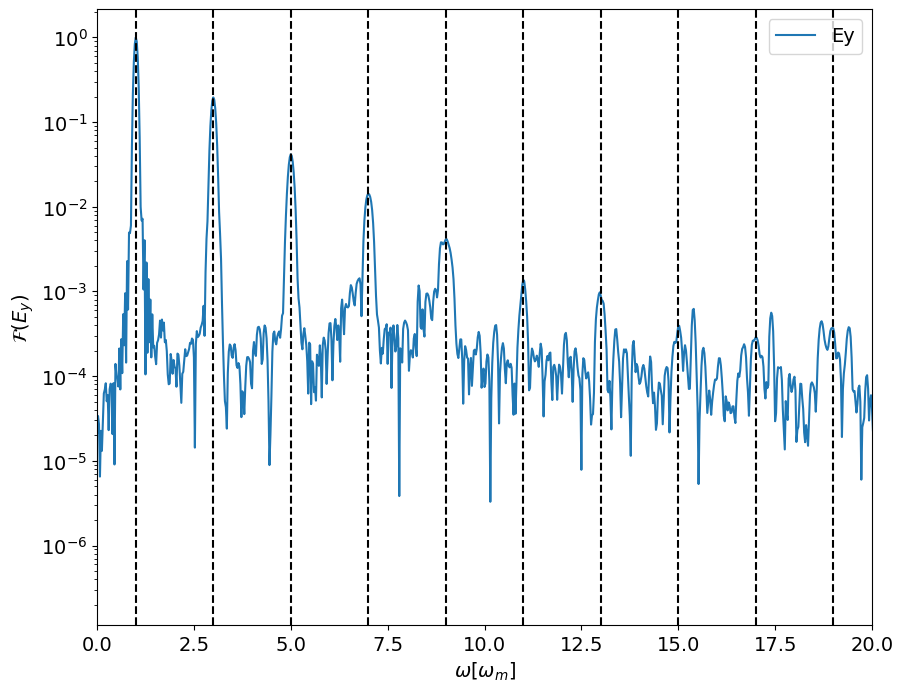

In [47]:
print(f"This is a {POL_TYPE}-polarized wave")
if POL_TYPE=="p":
    plot_p()
else:
    plot_s()

# Final Function

In [4]:
def plot(data_dir, save_dir=".", show_fig=True, file_name=None):
    DATA_DIR = data_dir
    SAVE_DIR = save_dir
    ALL_FILES = glob.glob(f"{DATA_DIR}/*sdf")
    ALL_FILES.sort()
    POINTS = len(ALL_FILES)

    with open(os.path.join(DATA_DIR, "input.deck"), "r") as myfile:
        data = myfile.read()

    def find_value(info):
        regex = re.compile(rf"\s{info}\s*=\s*-?(\d+\.?\d*)")
        regex2 = re.compile(rf"\s*{info}\s*=\s*(.*)\n")
        match = regex.search(data)
        match2 = regex2.search(data)

        if match:
            return float(match.group(1))

        if match2:
            return float(eval(match2.group(1)))
        else:
            return None

    LAMBD = find_value("lambda0") * 1e-6
    LAS_TIME = int(find_value("las_time"))
    T_MAX = int(find_value("t_end"))
    DT = find_value("dt_snapshot") * 1e-15
    A0 = find_value("a0")
    FACTOR = int(find_value("factor"))
    NX = int(find_value("nx"))
    X_MIN = -int(find_value("x_min"))
    ANGLE = find_value("alpha")
    pol = find_value("polarisation")

    if pol is None:
        POL_TYPE = "p"
        POL_ANGLE = 0
    else:
        if float(pol) == 90.0:
            POL_ANGLE = 90
            POL_TYPE = "s"
        else:
            POL_ANGLE = float(pol)
            POL_TYPE = "p"

    beta = np.cos((ANGLE))
    tan_factor = np.tan((ANGLE))

    lambda_0 = LAMBD
    omega_0 = 2 * PI * c / lambda_0
    tau_0 = 2 * PI / omega_0

    lambda_m = LAMBD / beta
    omega_m = 2 * PI * c / lambda_m
    tau_m = 2 * PI / omega_m
    dt_m = DT
    dt_l = DT

    lambda_l = lambda_0
    omega_l = omega_0
    tau_l = tau_0

    LAS_TIME_L = LAS_TIME * tau_l
    LAS_TIME_M = LAS_TIME * tau_m
    T_MAX_L = T_MAX * tau_l
    T_MAX_M = T_MAX * tau_m

    L_frame_info = {
        "lambda": lambda_l,
        "tau": tau_l,
        "omega": omega_l,
        "laser_time": LAS_TIME_L,
        "t_end": T_MAX_L,
        "dt_dump": dt_l,
        "a0": A0,
        "factor": FACTOR,
        "nx": NX,
        "x_min_natural": X_MIN * lambda_l,
        "x_min": X_MIN,
    }

    M_frame_info = {
        "lambda": lambda_m,
        "tau": tau_m,
        "omega": omega_m,
        "laser_time": LAS_TIME_M,
        "t_end": T_MAX_M,
        "dt_dump": dt_m,
        "a0": A0,
        "factor": FACTOR,
        "nx": NX,
        "x_min_natural": X_MIN * lambda_m,
        "x_min": X_MIN,
    }

    table = tabulate(
        [
            ["L", *L_frame_info.values()],
            ["M", *M_frame_info.values()],
        ],
        headers=["Frame", *L_frame_info.keys()],
        tablefmt="fancy_grid",
    )
    cprint(f"Values from input.deck of: {DATA_DIR}", "green")
    print("Number of Files:", POINTS)
    print(
        f"Angle: {ANGLE*180/(PI):.1f}",
    )
    print("Polarisation: ", POL_TYPE)
    print("Polarization Angle: ", POL_ANGLE)
    print(table)
    # return

    def plot_p(file_name, show_fig):
        omega_max_m = 2 * np.pi / dt_m
        omegas = np.linspace(-omega_max_m / 2, omega_max_m / 2, POINTS)
        omegas_l = omegas / beta

        Ety = np.zeros(POINTS)
        for i in tqdm(range(POINTS), "Loading Data..."):
            data = sdf.read(ALL_FILES[i])
            Ety[i] = data.Electric_Field_Ey.data[8000]

        # fft_x = np.fft.fftshift(np.fft.fft(Ety * tan_factor))
        fft_y = np.fft.fftshift(np.fft.fft(Ety))
        fft_y = np.abs(fft_y) / max(np.abs(fft_y))
        # fft_x = np.abs(fft_x) / max(np.abs(fft_x))

        plt.figure()
        # plt.plot(omegas / omega_m, fft_x, label="Ex")
        plt.plot(omegas / omega_m, fft_y, label="$E_y$")
        plt.xlabel(r"$\omega [\omega_m]$")
        # plt.plot(omegas_l / omega_0, fft_x, label="Ex")
        # plt.plot(omegas_l / omega_0, fft_y, label="Ey")
        # plt.xlabel(r"$\omega [\omega_l]$")
        plt.ylabel(r"$\mathcal{F}(E_y)$")
        plt.legend()
        plt.yscale("log")
        plt.xlim(0, 20)
        # x_ticks = np.arange(0, 21, 2)
        lines = np.arange(1, 41, 2)
        for line in lines:
            plt.axvline(line, color="k", linestyle="--", alpha=1)

        if file_name:
            plt.savefig(os.path.join(SAVE_DIR, f"{file_name}.png"))

        if show_fig:
            plt.show()
        else:
            plt.close()

    def plot_s(file_name, show_fig):
        omega_max_m = 2 * np.pi / dt_m
        omegas = np.linspace(-omega_max_m / 2, omega_max_m / 2, POINTS)
        omegas_l = omegas / beta

        Etz = np.zeros(POINTS)
        Etx = np.zeros(POINTS)
        for i in tqdm(range(POINTS), "Loading Data..."):
            data = sdf.read(ALL_FILES[i])
            Etz[i] = data.Electric_Field_Ez.data[8000]
            Etx[i] = data.Electric_Field_Ex.data[8000]

        fft_z = np.fft.fftshift(np.fft.fft(Etz / beta))
        # fft_z = np.abs(fft_z) / max(np.abs(fft_z * tan_factor))
        fft_z = np.abs(fft_z)
        fft_x = np.fft.fftshift(np.fft.fft(Etx))
        # fft_x = np.abs(fft_x) / max(np.abs(fft_x))
        fft_x = np.abs(fft_x)

        plt.figure()
        plt.plot(omegas / omega_m, fft_z, label="$E_z$")
        plt.plot(omegas / omega_m, fft_x, label="$E_x$")
        plt.xlabel(r"$\omega [\omega_m]$")
        # plt.plot(omegas_l / omega_0, fft_x, label="Ex")
        # plt.plot(omegas_l / omega_0, fft_y, label="Ey")
        # plt.xlabel(r"$\omega [\omega_l]$")
        plt.ylabel(r"$\mathcal{F}(E_y)$")
        plt.legend()
        plt.yscale("log")
        plt.xlim(0, 20)
        # x_ticks = np.arange(0, 21, 2)
        lines = np.arange(1, 41, 1)
        for line in lines:
            plt.axvline(line, color="k", linestyle="--", alpha=1)

        if file_name:
            plt.savefig(os.path.join(SAVE_DIR, f"{file_name}.png"))

        if show_fig:
            plt.show()
        else:
            plt.close()

    print(f"This is a {POL_TYPE}-polarized wave")
    if POL_TYPE == "p":
        plot_p(file_name=file_name, show_fig=show_fig)
    else:
        plot_s(file_name=file_name, show_fig=show_fig)

Values from input.deck of: run_1
Number of Files: 4449
Angle: 60.0
Polarisation:  p
Polarization Angle:  0
╒═════════╤══════════╤═════════════╤═════════════╤══════════════╤═════════════╤═══════════╤══════╤══════════╤═══════╤═════════════════╤═════════╕
│ Frame   │   lambda │         tau │       omega │   laser_time │       t_end │   dt_dump │   a0 │   factor │    nx │   x_min_natural │   x_min │
╞═════════╪══════════╪═════════════╪═════════════╪══════════════╪═════════════╪═══════════╪══════╪══════════╪═══════╪═════════════════╪═════════╡
│ L       │    1e-06 │ 3.33564e-15 │ 1.88365e+15 │  6.67128e-14 │ 1.33426e-13 │     6e-17 │    4 │        7 │ 16000 │          -2e-05 │     -20 │
├─────────┼──────────┼─────────────┼─────────────┼──────────────┼─────────────┼───────────┼──────┼──────────┼───────┼─────────────────┼─────────┤
│ M       │    2e-06 │ 6.67128e-15 │ 9.41826e+14 │  1.33426e-13 │ 2.66851e-13 │     6e-17 │    4 │        7 │ 16000 │          -4e-05 │     -20 │
╘═════════╧══════

Loading Data...: 100%|██████████| 4449/4449 [00:11<00:00, 381.88it/s]


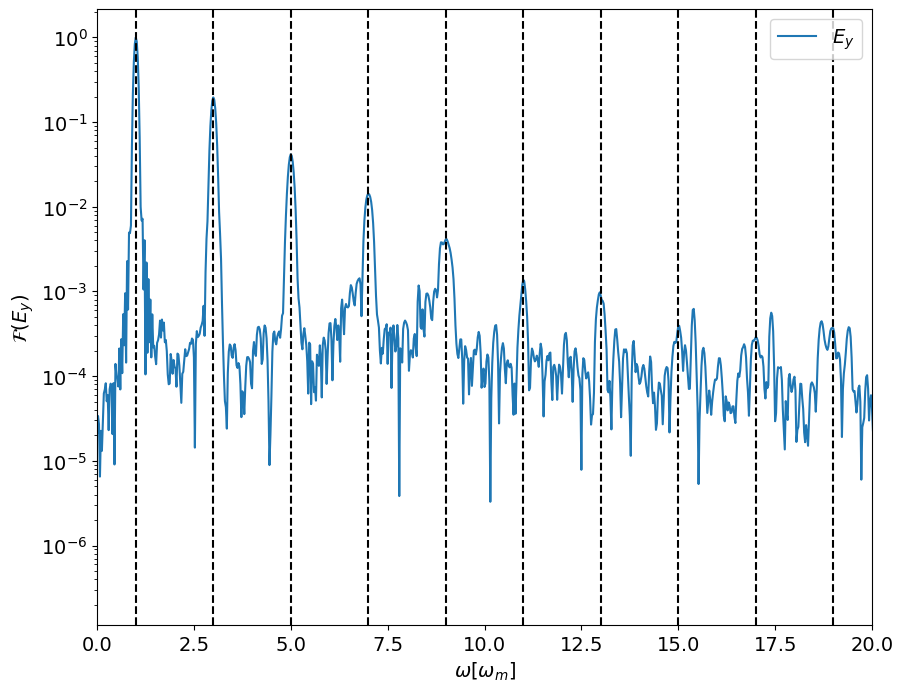

In [4]:
plot("run_1")

Values from input.deck of: run_2
Number of Files: 2225
Angle: 0.0
Polarisation:  p
Polarization Angle:  0
╒═════════╤══════════╤═════════════╤═════════════╤══════════════╤═════════════╤═══════════════╤══════╤══════════╤═══════╤═════════════════╤═════════╕
│ Frame   │   lambda │         tau │       omega │   laser_time │       t_end │   dt_snapshot │   a0 │   factor │    nx │   x_min_natural │   x_min │
╞═════════╪══════════╪═════════════╪═════════════╪══════════════╪═════════════╪═══════════════╪══════╪══════════╪═══════╪═════════════════╪═════════╡
│ L Frame │    1e-06 │ 3.33564e-15 │ 1.88365e+15 │  6.67128e-14 │ 1.33426e-13 │         6e-17 │    4 │        7 │ 16000 │          -2e-05 │     -20 │
├─────────┼──────────┼─────────────┼─────────────┼──────────────┼─────────────┼───────────────┼──────┼──────────┼───────┼─────────────────┼─────────┤
│ M Frame │    1e-06 │ 3.33564e-15 │ 1.88365e+15 │  6.67128e-14 │ 1.33426e-13 │         6e-17 │    4 │        7 │ 16000 │          -2e-05 │     

Loading Data...: 100%|██████████| 2225/2225 [00:05<00:00, 424.10it/s]


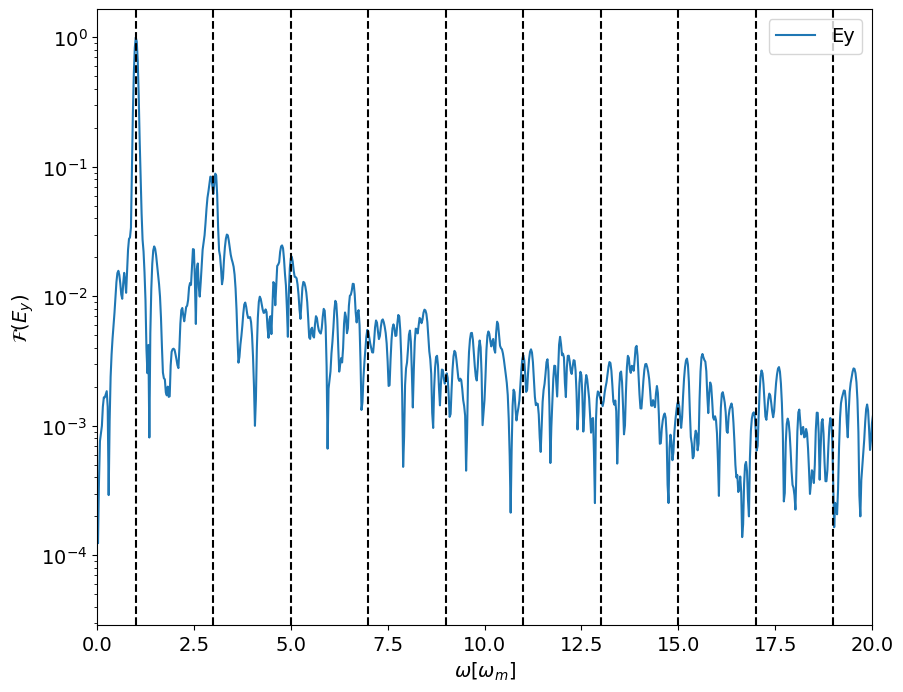

In [50]:
plot("run_2")

Values from input.deck of: run_3
Number of Files: 2569
Angle: 30.0
Polarisation:  p
Polarization Angle:  0
╒═════════╤════════════╤═════════════╤═════════════╤══════════════╤═════════════╤═══════════════╤══════╤══════════╤═══════╤═════════════════╤═════════╕
│ Frame   │     lambda │         tau │       omega │   laser_time │       t_end │   dt_snapshot │   a0 │   factor │    nx │   x_min_natural │   x_min │
╞═════════╪════════════╪═════════════╪═════════════╪══════════════╪═════════════╪═══════════════╪══════╪══════════╪═══════╪═════════════════╪═════════╡
│ L Frame │ 1e-06      │ 3.33564e-15 │ 1.88365e+15 │  6.67128e-14 │ 1.33426e-13 │         6e-17 │    4 │        7 │ 16000 │     -2e-05      │     -20 │
├─────────┼────────────┼─────────────┼─────────────┼──────────────┼─────────────┼───────────────┼──────┼──────────┼───────┼─────────────────┼─────────┤
│ M Frame │ 1.1547e-06 │ 3.85167e-15 │ 1.63129e+15 │  7.70333e-14 │ 1.54067e-13 │         6e-17 │    4 │        7 │ 16000 │     -2.30

Loading Data...: 100%|██████████| 2569/2569 [00:05<00:00, 456.12it/s]


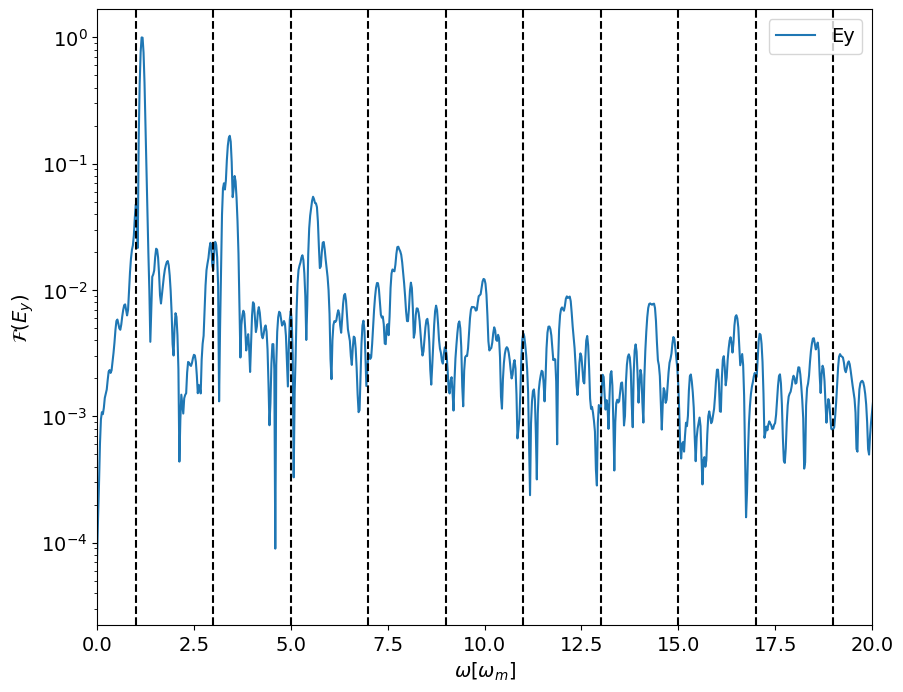

In [4]:
plot("run_3")

Values from input.deck of: run_4
Number of Files: 4449
Angle: 60.0
Polarisation:  s
Polarization Angle:  90
╒═════════╤══════════╤═════════════╤═════════════╤══════════════╤═════════════╤═══════════╤══════╤══════════╤═══════╤═════════════════╤═════════╕
│ Frame   │   lambda │         tau │       omega │   laser_time │       t_end │   dt_dump │   a0 │   factor │    nx │   x_min_natural │   x_min │
╞═════════╪══════════╪═════════════╪═════════════╪══════════════╪═════════════╪═══════════╪══════╪══════════╪═══════╪═════════════════╪═════════╡
│ L       │    1e-06 │ 3.33564e-15 │ 1.88365e+15 │  6.67128e-14 │ 1.33426e-13 │     6e-17 │    4 │        7 │ 16000 │          -2e-05 │     -20 │
├─────────┼──────────┼─────────────┼─────────────┼──────────────┼─────────────┼───────────┼──────┼──────────┼───────┼─────────────────┼─────────┤
│ M       │    2e-06 │ 6.67128e-15 │ 9.41826e+14 │  1.33426e-13 │ 2.66851e-13 │     6e-17 │    4 │        7 │ 16000 │          -4e-05 │     -20 │
╘═════════╧═════

Loading Data...: 100%|██████████| 4449/4449 [00:18<00:00, 242.76it/s]


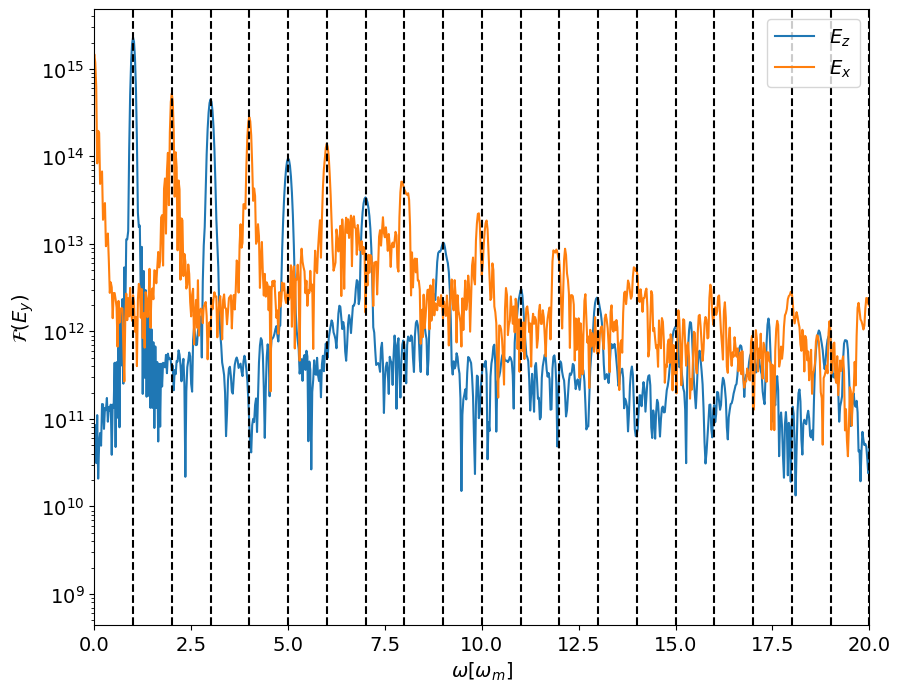

In [5]:
plot("run_4")

Values from input.deck of: run_5
Number of Files: 3146
Angle: 45.0
Polarisation:  s
Polarization Angle:  90
╒═════════╤═════════════╤═════════════╤═════════════╤══════════════╤═════════════╤═══════════╤══════╤══════════╤═══════╤═════════════════╤═════════╕
│ Frame   │      lambda │         tau │       omega │   laser_time │       t_end │   dt_dump │   a0 │   factor │    nx │   x_min_natural │   x_min │
╞═════════╪═════════════╪═════════════╪═════════════╪══════════════╪═════════════╪═══════════╪══════╪══════════╪═══════╪═════════════════╪═════════╡
│ L       │ 1e-06       │ 3.33564e-15 │ 1.88365e+15 │  6.67128e-14 │ 1.33426e-13 │     6e-17 │    4 │        7 │ 16000 │    -2e-05       │     -20 │
├─────────┼─────────────┼─────────────┼─────────────┼──────────────┼─────────────┼───────────┼──────┼──────────┼───────┼─────────────────┼─────────┤
│ M       │ 1.41421e-06 │ 4.71731e-15 │ 1.33194e+15 │  9.43462e-14 │ 1.88692e-13 │     6e-17 │    4 │        7 │ 16000 │    -2.82843e-05 │     -20 

Loading Data...: 100%|██████████| 3146/3146 [00:12<00:00, 255.08it/s]


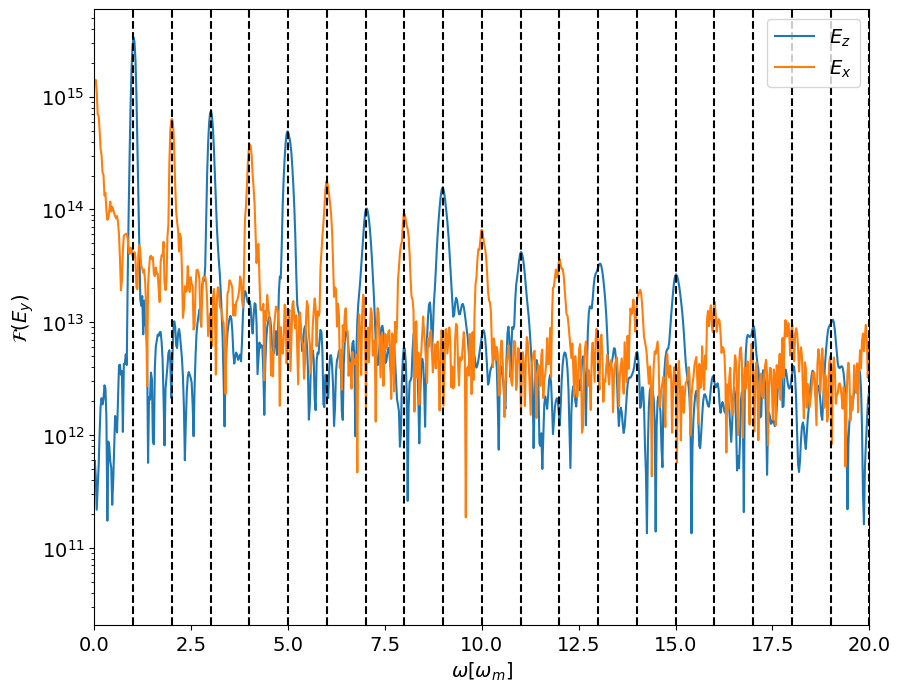

In [5]:
plot("run_5")

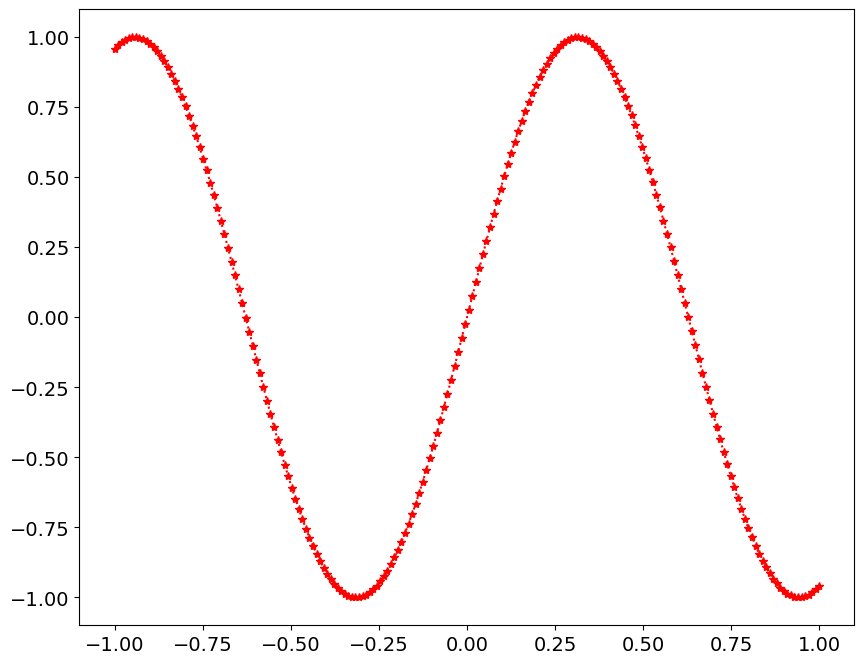

In [15]:
X = np.linspace(-1,1,200)
Y = np.sin(5*X)

plt.plot(X, Y, color="red", marker="*", ls=":")